In [1]:
import pm4py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
log_low = pm4py.read_xes('data/renting_log_low.xes')
log_medium = pm4py.read_xes('data/renting_log_medium.xes')
log_high = pm4py.read_xes('data/renting_log_high.xes')

parsing log, completed traces :: 100%|██████████| 10000/10000 [00:02<00:00, 3696.94it/s]


In [4]:
def flat_dataset(log):
    flat_data = log \
        .groupby(['case:case']) \
        .agg(
            germanSpeaking=('case:german speaking', 'first'),
            yearsOfEducation=('case:yearsOfEducation', 'first'),
            age=('case:age', 'first'),
            gender=('case:gender', 'first'),
            citizen=('case:citizen', 'first'),
            protected=('case:protected', 'first'),
            married=('case:married', 'first')
        )
    
    flat_data['ageGroup25'] = pd.cut(
        flat_data['age'],
        bins=[0, 25, 50, 200],
        labels=['0-25', '25-50', '>50']
    )

    flat_data['ageGroup10'] = pd.cut(
        flat_data['age'],
        bins=[0, 30, 40, 50, 60, 70, 200],
        labels=['0-30', '30-40', '40-50', '50-60', '60-70', '>70']
    )
    
    flat_data['screening'] = log \
        .groupby(['case:case'])['concept:name'] \
        .transform(lambda x: 'Screen Prospective Tenant' in x.values)
    
    flat_data['extensiveScreening'] = log \
        .groupby(['case:case'])['concept:name'] \
        .transform(lambda x: 'Extensive Screening' in x.values)
    
    flat_data['contract'] = log \
        .groupby(['case:case'])['concept:name'] \
        .transform(lambda x: 'Sign Contract' in x.values)
    
    flat_data['denied'] = log \
        .groupby(['case:case'])['concept:name'] \
        .transform(lambda x: 'Reject Prospective Tenant' in x.values)
    
    flat_data['missedPayments'] = log \
        .groupby(['case:case'])['concept:name'] \
        .transform(lambda x: x.str.contains('Miss Rent Payment').sum())
    
    flat_data['latePayments'] = log \
        .groupby(['case:case'])['concept:name'] \
        .transform(lambda x: x.str.contains('Accept Late Payment').sum())
    
    flat_data['evicted'] = log \
        .groupby(['case:case'])['concept:name'] \
        .transform(lambda x: 'Evict Tenant' in x.values)
    
    flat_data['cancelled'] = log \
        .groupby(['case:case'])['concept:name'] \
        .transform(lambda x: 'Tenant Cancels Appartment' in x.values)
    
    flat_data['duration'] = log \
        .groupby(['case:case'])['time:timestamp'] \
        .transform(lambda x: (x.max() - x.min()).days)

    return flat_data

In [5]:
flat_low = flat_dataset(log_low)
flat_medium = flat_dataset(log_medium)
flat_high = flat_dataset(log_high)

In [6]:
flat_low

,germanSpeaking,yearsOfEducation,age,gender,citizen,protected,married,ageGroup25,ageGroup10,screening,extensiveScreening,contract,denied,missedPayments,latePayments,evicted,cancelled,duration
case:case,,,,,,,,,,,,,,,,,,
1,False,8,25,False,False,False,True,0-25,0-30,True,False,True,False,0,0,False,True,9
2,False,7,53,False,False,False,False,>50,50-60,True,False,True,False,0,0,False,True,9
3,False,4,46,True,False,False,True,25-50,40-50,True,False,True,False,0,0,False,True,9
4,True,12,49,True,True,False,False,25-50,40-50,True,False,True,False,0,0,False,True,9
5,True,2,62,False,False,True,False,>50,60-70,True,False,True,False,0,0,False,True,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,False,1,59,True,True,True,True,>50,50-60,True,False,True,False,1,0,True,False,10
9997,True,6,59,True,True,False,False,>50,50-60,True,False,True,False,1,0,True,False,10
9998,False,12,40,True,True,False,True,25-50,30-40,True,False,True,False,1,0,True,False,10


## Acceptance / Denial

In [7]:
def print_acceptance_denial_counts():
    for column in ['gender', 'ageGroup25', 'germanSpeaking', 'married', 'citizen', 'protected', 'yearsOfEducation']:
        print('-------------------------------------------------------')
        print('Column: ', column)

        for dataset_name, dataset in [('low', flat_low), ('medium', flat_medium), ('high', flat_high)]:
            print(f'\tDataset: {dataset_name}')

            distinct_values = dataset[column].unique()

            for value in sorted(distinct_values):
                accepted_n = len(dataset[(dataset[column] == value) & (dataset['contract'] == True)])
                denied_n = len(dataset[(dataset[column] == value) & (dataset['denied'] == True)])
                total_n = len(dataset[dataset[column] == value])

                print("\t\tValue: ", value)
                print('\t\t- Accepted: ', accepted_n, '->', round(accepted_n / total_n, 5) * 100, '%' )
                print('\t\t- Denied: ', denied_n, '->', round(denied_n / total_n, 5) * 100, '%' )
                print()

        # plot bar chart for all three datasets in a same figure
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(column)

        sns.countplot(x=column, hue='contract', data=flat_low, ax=ax[0])
        ax[0].set_title('low')

        sns.countplot(x=column, hue='contract', data=flat_medium, ax=ax[1])
        ax[1].set_title('medium')

        sns.countplot(x=column, hue='contract', data=flat_high, ax=ax[2])
        ax[2].set_title('high')

        plt.show()

-------------------------------------------------------
Column:  gender
	Dataset: low
		Value:  False
		- Accepted:  2523 -> 56.40500000000001 %
		- Denied:  1950 -> 43.595 %

		Value:  True
		- Accepted:  3197 -> 57.843 %
		- Denied:  2330 -> 42.157 %

	Dataset: medium
		Value:  False
		- Accepted:  3370 -> 65.988 %
		- Denied:  1737 -> 34.012 %

		Value:  True
		- Accepted:  3209 -> 65.583 %
		- Denied:  1684 -> 34.416999999999994 %

	Dataset: high
		Value:  False
		- Accepted:  2185 -> 51.888 %
		- Denied:  2026 -> 48.112 %

		Value:  True
		- Accepted:  3004 -> 51.892 %
		- Denied:  2785 -> 48.108000000000004 %



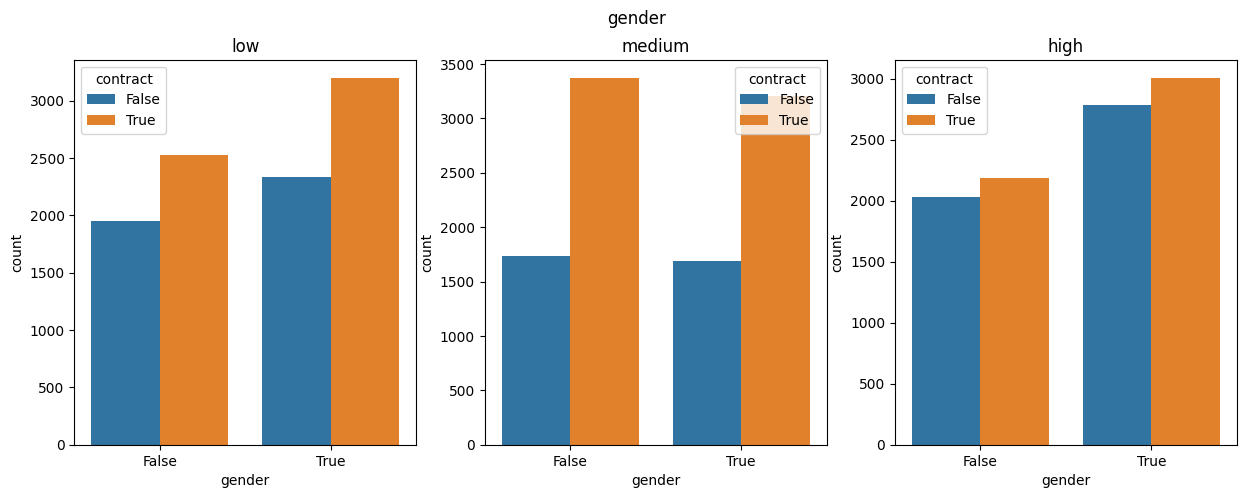

-------------------------------------------------------
Column:  ageGroup25
	Dataset: low
		Value:  0-25
		- Accepted:  31 -> 64.583 %
		- Denied:  17 -> 35.417 %

		Value:  25-50
		- Accepted:  2631 -> 56.230000000000004 %
		- Denied:  2048 -> 43.769999999999996 %

		Value:  >50
		- Accepted:  3058 -> 57.994 %
		- Denied:  2215 -> 42.006 %

	Dataset: medium
		Value:  0-25
		- Accepted:  28 -> 54.901999999999994 %
		- Denied:  23 -> 45.098 %

		Value:  25-50
		- Accepted:  3237 -> 66.156 %
		- Denied:  1656 -> 33.844 %

		Value:  >50
		- Accepted:  3314 -> 65.546 %
		- Denied:  1742 -> 34.454 %

	Dataset: high
		Value:  0-25
		- Accepted:  32 -> 56.14 %
		- Denied:  25 -> 43.86 %

		Value:  25-50
		- Accepted:  2827 -> 52.449 %
		- Denied:  2563 -> 47.551 %

		Value:  >50
		- Accepted:  2330 -> 51.175000000000004 %
		- Denied:  2223 -> 48.825 %



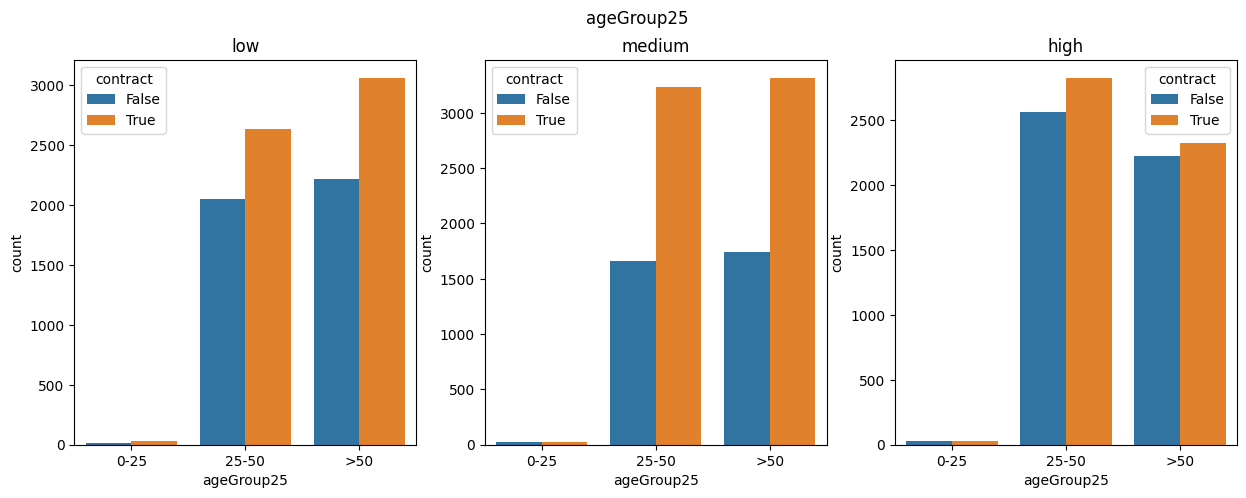

-------------------------------------------------------
Column:  germanSpeaking
	Dataset: low
		Value:  False
		- Accepted:  2550 -> 57.342000000000006 %
		- Denied:  1897 -> 42.658 %

		Value:  True
		- Accepted:  3170 -> 57.086000000000006 %
		- Denied:  2383 -> 42.914 %

	Dataset: medium
		Value:  False
		- Accepted:  2303 -> 66.77300000000001 %
		- Denied:  1146 -> 33.227000000000004 %

		Value:  True
		- Accepted:  4276 -> 65.27199999999999 %
		- Denied:  2275 -> 34.727999999999994 %

	Dataset: high
		Value:  False
		- Accepted:  2665 -> 52.347 %
		- Denied:  2426 -> 47.653 %

		Value:  True
		- Accepted:  2524 -> 51.416 %
		- Denied:  2385 -> 48.583999999999996 %



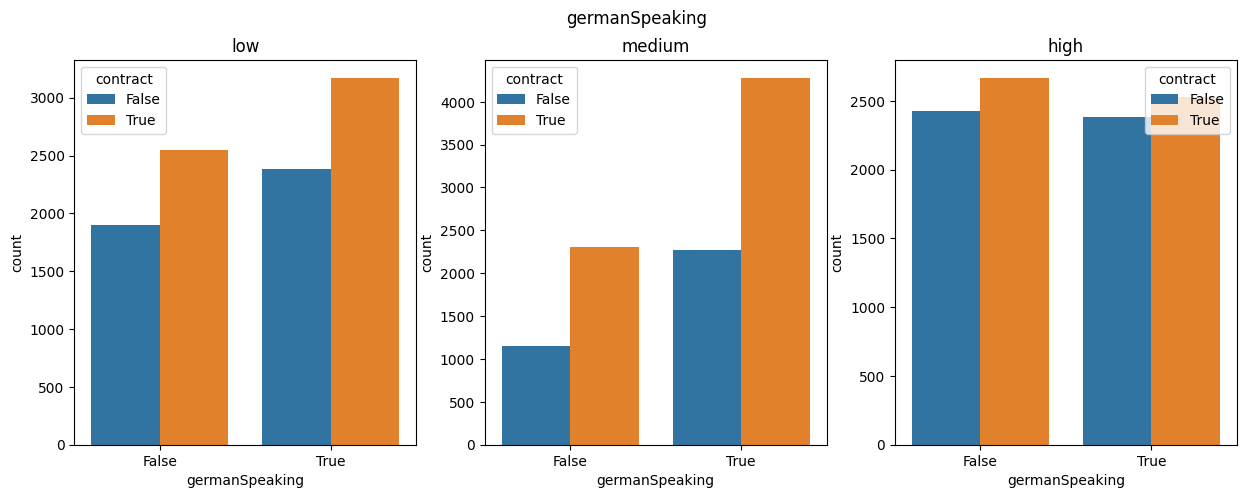

-------------------------------------------------------
Column:  married
	Dataset: low
		Value:  False
		- Accepted:  2523 -> 58.053 %
		- Denied:  1823 -> 41.947 %

		Value:  True
		- Accepted:  3197 -> 56.544000000000004 %
		- Denied:  2457 -> 43.456 %

	Dataset: medium
		Value:  False
		- Accepted:  2217 -> 65.592 %
		- Denied:  1163 -> 34.408 %

		Value:  True
		- Accepted:  4362 -> 65.891 %
		- Denied:  2258 -> 34.109 %

	Dataset: high
		Value:  False
		- Accepted:  2559 -> 51.551 %
		- Denied:  2405 -> 48.449 %

		Value:  True
		- Accepted:  2630 -> 52.224000000000004 %
		- Denied:  2406 -> 47.776 %



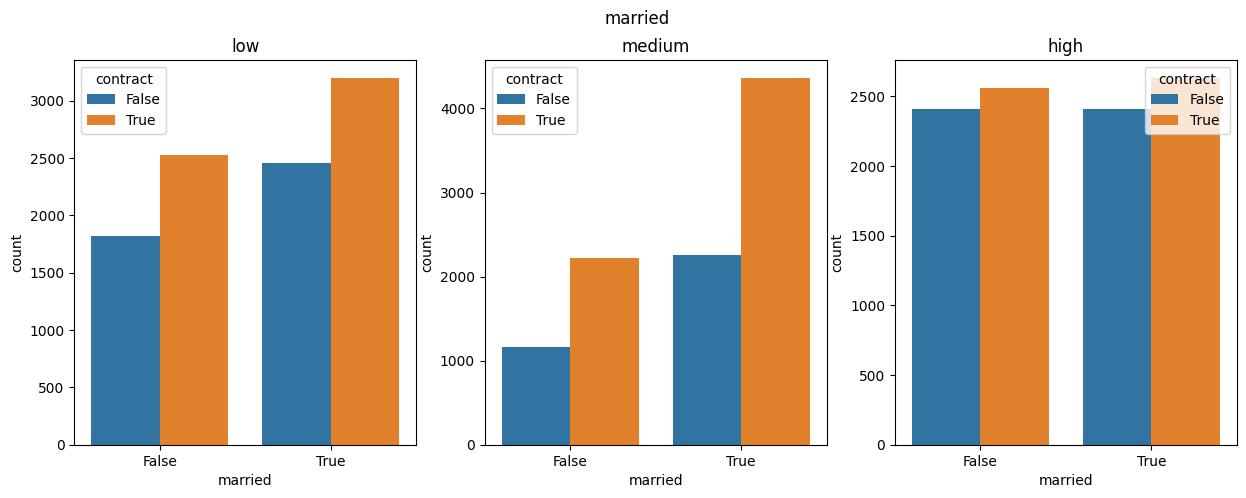

-------------------------------------------------------
Column:  citizen
	Dataset: low
		Value:  False
		- Accepted:  2527 -> 57.237 %
		- Denied:  1888 -> 42.763 %

		Value:  True
		- Accepted:  3193 -> 57.17100000000001 %
		- Denied:  2392 -> 42.829 %

	Dataset: medium
		Value:  False
		- Accepted:  2194 -> 65.551 %
		- Denied:  1153 -> 34.449000000000005 %

		Value:  True
		- Accepted:  4385 -> 65.91 %
		- Denied:  2268 -> 34.089999999999996 %

	Dataset: high
		Value:  False
		- Accepted:  2580 -> 51.714000000000006 %
		- Denied:  2409 -> 48.286 %

		Value:  True
		- Accepted:  2609 -> 52.065 %
		- Denied:  2402 -> 47.935 %



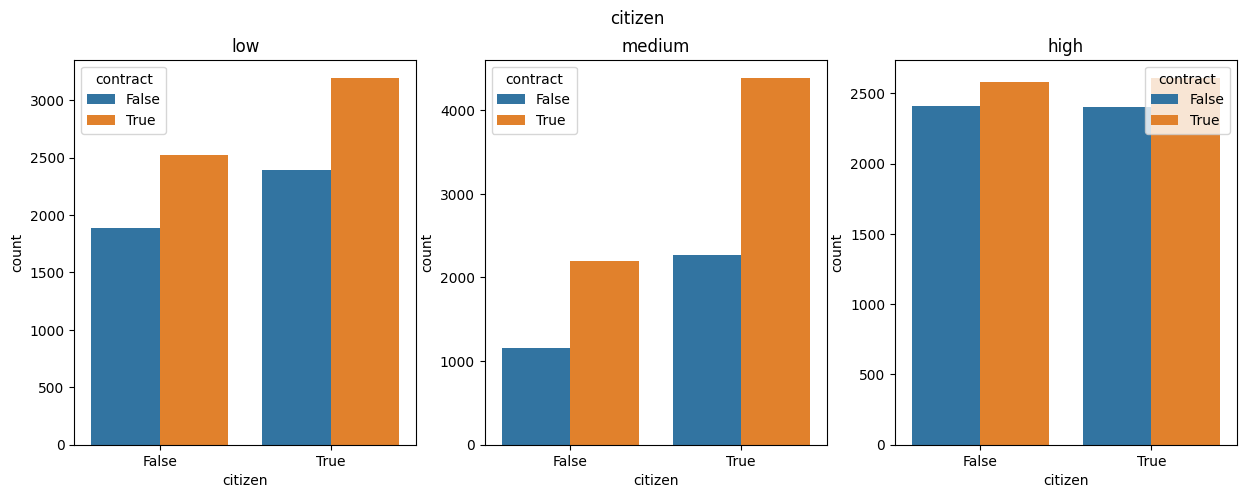

-------------------------------------------------------
Column:  protected
	Dataset: low
		Value:  False
		- Accepted:  4568 -> 57.028999999999996 %
		- Denied:  3442 -> 42.971 %

		Value:  True
		- Accepted:  1152 -> 57.889 %
		- Denied:  838 -> 42.111 %

	Dataset: medium
		Value:  False
		- Accepted:  5939 -> 65.901 %
		- Denied:  3073 -> 34.099000000000004 %

		Value:  True
		- Accepted:  640 -> 64.777 %
		- Denied:  348 -> 35.223 %

	Dataset: high
		Value:  False
		- Accepted:  3676 -> 52.38 %
		- Denied:  3342 -> 47.620000000000005 %

		Value:  True
		- Accepted:  1513 -> 50.73800000000001 %
		- Denied:  1469 -> 49.262 %



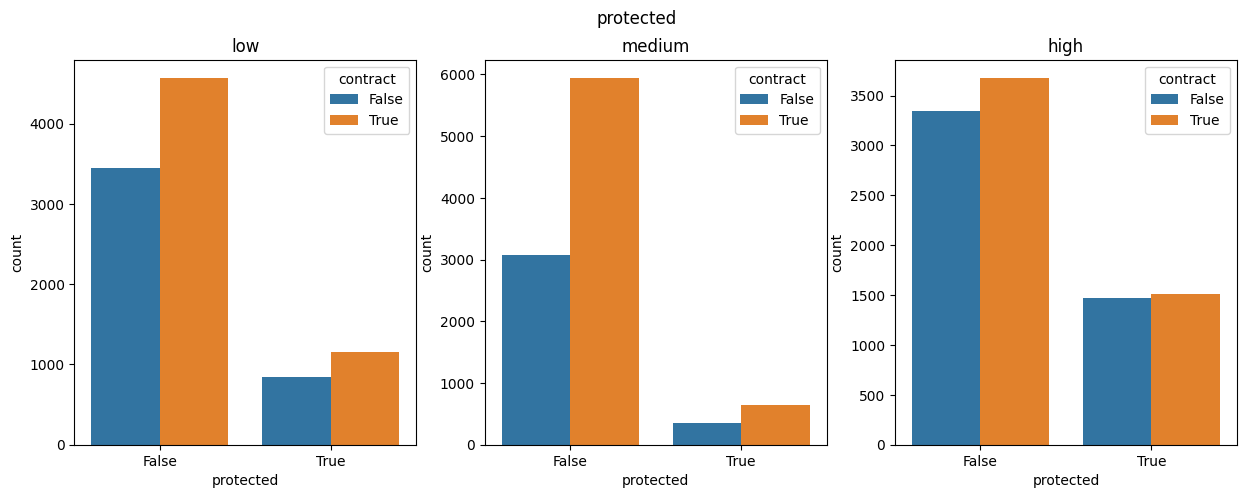

-------------------------------------------------------
Column:  yearsOfEducation
	Dataset: low
		Value:  1
		- Accepted:  174 -> 56.678 %
		- Denied:  133 -> 43.322 %

		Value:  2
		- Accepted:  115 -> 56.373 %
		- Denied:  89 -> 43.627 %

		Value:  3
		- Accepted:  196 -> 56.977 %
		- Denied:  148 -> 43.023 %

		Value:  4
		- Accepted:  270 -> 58.952000000000005 %
		- Denied:  188 -> 41.048 %

		Value:  5
		- Accepted:  340 -> 57.626999999999995 %
		- Denied:  250 -> 42.373 %

		Value:  6
		- Accepted:  456 -> 59.763999999999996 %
		- Denied:  307 -> 40.236 %

		Value:  7
		- Accepted:  497 -> 54.081 %
		- Denied:  422 -> 45.919 %

		Value:  8
		- Accepted:  615 -> 56.63 %
		- Denied:  471 -> 43.37 %

		Value:  9
		- Accepted:  669 -> 55.75 %
		- Denied:  531 -> 44.25 %

		Value:  10
		- Accepted:  678 -> 58.196999999999996 %
		- Denied:  487 -> 41.803000000000004 %

		Value:  11
		- Accepted:  604 -> 59.041999999999994 %
		- Denied:  419 -> 40.958 %

		Value:  12
		- Accepted:  436 

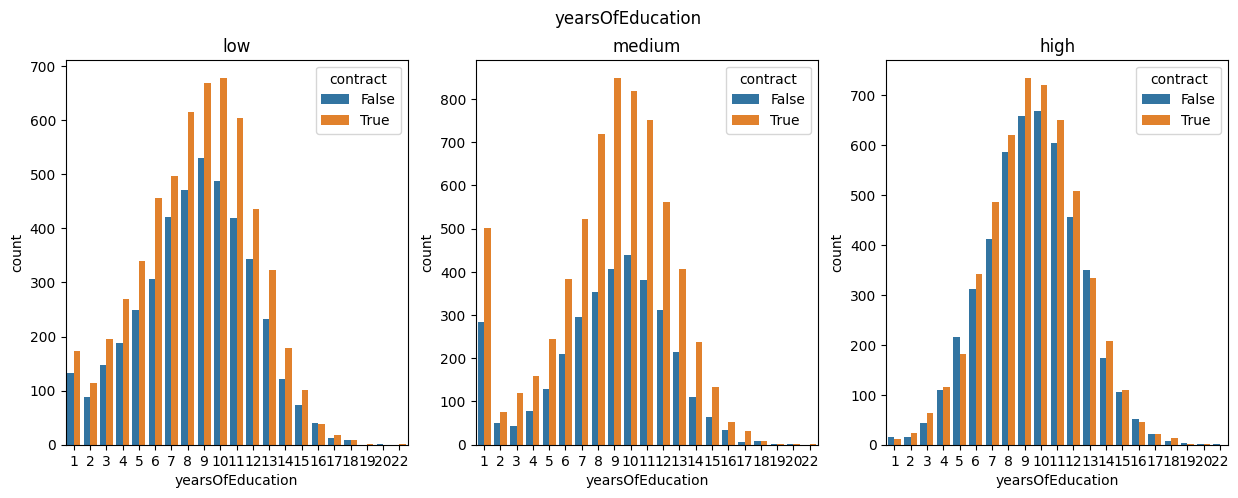

In [8]:
print_acceptance_denial_counts()

## Eviction / Cancelation

In [9]:
def print_eviction_cancellation_counts():
    for column in ['gender', 'ageGroup10', 'germanSpeaking', 'married', 'citizen', 'protected', 'yearsOfEducation']:
        print('-------------------------------------------------------')
        print('Column: ', column)

        for dataset_name, dataset in [('low', flat_low), ('medium', flat_medium), ('high', flat_high)]:
            print(f'\tDataset: {dataset_name}')

            distinct_values = dataset[column].unique()

            for value in sorted(distinct_values):
                evicted_n = len(dataset[(dataset[column] == value) & (dataset['contract'] == True) & (dataset['evicted'] == True)])
                canceled_n = len(dataset[(dataset[column] == value) & (dataset['contract'] == True) & (dataset['cancelled'] == True)])
                total_n = len(dataset[(dataset[column] == value) & (dataset['contract'] == True)]) + 1e-10

                print("\t\tValue: ", value)
                print(f"\t\t- Evicted: {evicted_n} -> {round(evicted_n / total_n, 5) * 100} %")
                print(f"\t\t- Canceled: {canceled_n} -> {round(canceled_n / total_n, 5) * 100} %")
                print()

        # plot bar chart for all three datasets in a same figure
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(column)

        sns.countplot(x=column, hue='evicted', data=flat_low[flat_low['contract'] == True], ax=ax[0])
        ax[0].set_title('low')

        sns.countplot(x=column, hue='evicted', data=flat_medium[flat_medium['contract'] == True], ax=ax[1])
        ax[1].set_title('medium')

        sns.countplot(x=column, hue='evicted', data=flat_high[flat_high['contract'] == True], ax=ax[2])
        ax[2].set_title('high')

        plt.show()



-------------------------------------------------------
Column:  gender
	Dataset: low
		Value:  False
		- Evicted: 78 -> 3.092 %
		- Canceled: 2445 -> 96.908 %

		Value:  True
		- Evicted: 125 -> 3.91 %
		- Canceled: 3072 -> 96.09 %

	Dataset: medium
		Value:  False
		- Evicted: 190 -> 5.638 %
		- Canceled: 3180 -> 94.362 %

		Value:  True
		- Evicted: 200 -> 6.232 %
		- Canceled: 3009 -> 93.768 %

	Dataset: high
		Value:  False
		- Evicted: 86 -> 3.936 %
		- Canceled: 2099 -> 96.06400000000001 %

		Value:  True
		- Evicted: 91 -> 3.029 %
		- Canceled: 2913 -> 96.97099999999999 %



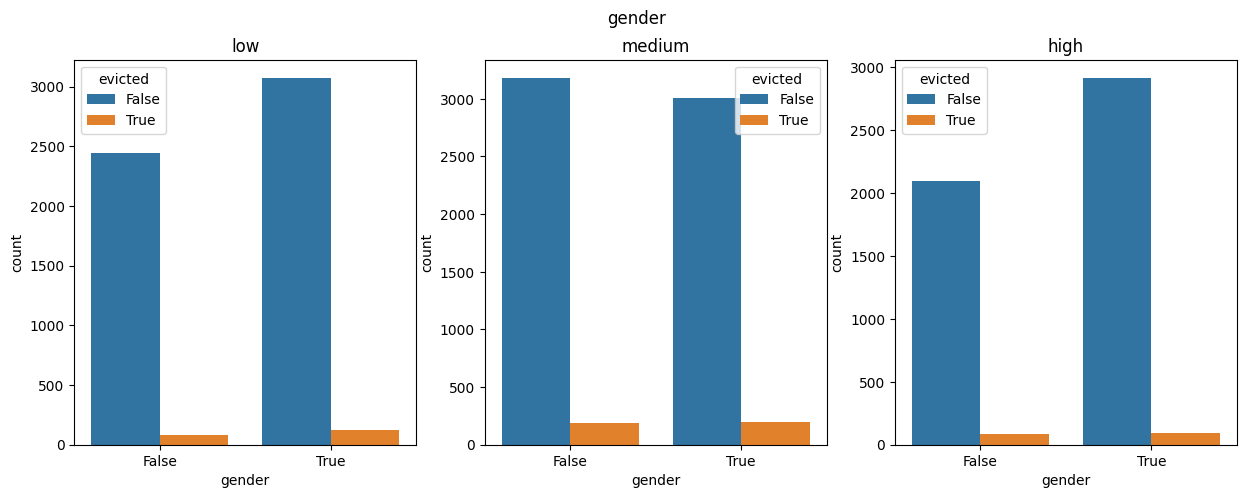

-------------------------------------------------------
Column:  ageGroup10
	Dataset: low
		Value:  0-30
		- Evicted: 4 -> 4.04 %
		- Canceled: 95 -> 95.96000000000001 %

		Value:  30-40
		- Evicted: 25 -> 3.759 %
		- Canceled: 640 -> 96.241 %

		Value:  40-50
		- Evicted: 68 -> 3.583 %
		- Canceled: 1830 -> 96.417 %

		Value:  50-60
		- Evicted: 65 -> 3.345 %
		- Canceled: 1878 -> 96.655 %

		Value:  60-70
		- Evicted: 33 -> 3.56 %
		- Canceled: 894 -> 96.44 %

		Value:  >70
		- Evicted: 8 -> 4.255 %
		- Canceled: 180 -> 95.745 %

	Dataset: medium
		Value:  0-30
		- Evicted: 8 -> 7.407 %
		- Canceled: 100 -> 92.593 %

		Value:  30-40
		- Evicted: 56 -> 6.356000000000001 %
		- Canceled: 825 -> 93.644 %

		Value:  40-50
		- Evicted: 138 -> 6.063000000000001 %
		- Canceled: 2138 -> 93.937 %

		Value:  50-60
		- Evicted: 107 -> 5.2299999999999995 %
		- Canceled: 1939 -> 94.77 %

		Value:  60-70
		- Evicted: 57 -> 6.264 %
		- Canceled: 853 -> 93.73599999999999 %

		Value:  >70
		- Evicted:

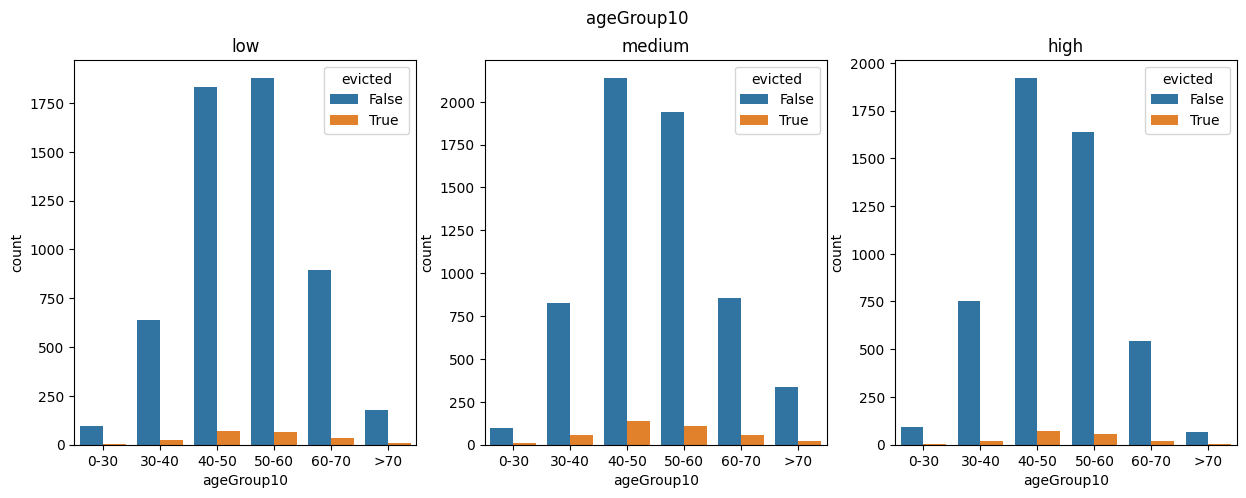

-------------------------------------------------------
Column:  germanSpeaking
	Dataset: low
		Value:  False
		- Evicted: 86 -> 3.373 %
		- Canceled: 2464 -> 96.627 %

		Value:  True
		- Evicted: 117 -> 3.691 %
		- Canceled: 3053 -> 96.309 %

	Dataset: medium
		Value:  False
		- Evicted: 136 -> 5.905 %
		- Canceled: 2167 -> 94.095 %

		Value:  True
		- Evicted: 254 -> 5.94 %
		- Canceled: 4022 -> 94.06 %

	Dataset: high
		Value:  False
		- Evicted: 101 -> 3.7900000000000005 %
		- Canceled: 2564 -> 96.21 %

		Value:  True
		- Evicted: 76 -> 3.011 %
		- Canceled: 2448 -> 96.989 %



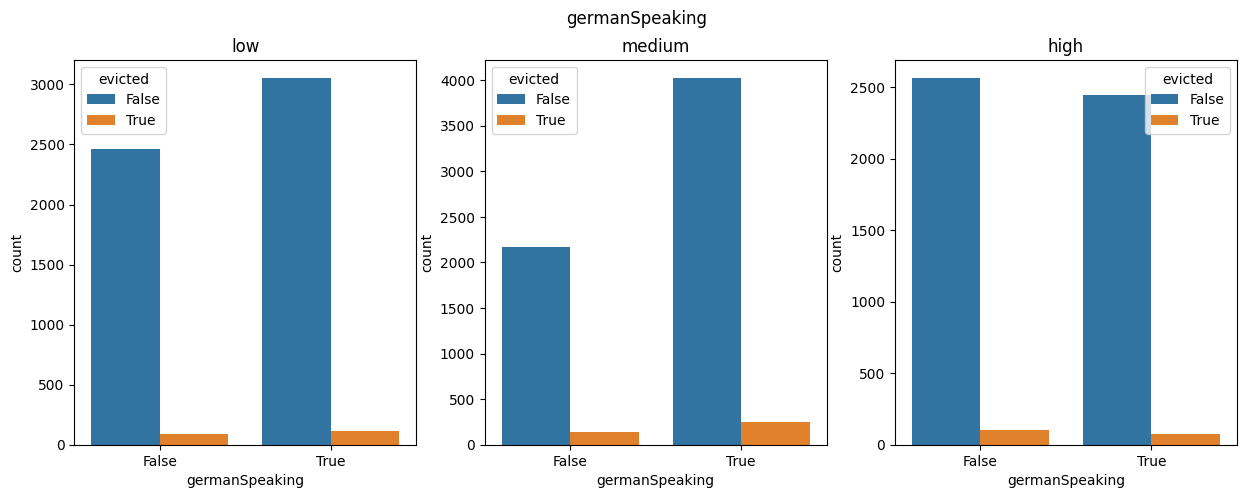

-------------------------------------------------------
Column:  married
	Dataset: low
		Value:  False
		- Evicted: 101 -> 4.003 %
		- Canceled: 2422 -> 95.997 %

		Value:  True
		- Evicted: 102 -> 3.19 %
		- Canceled: 3095 -> 96.81 %

	Dataset: medium
		Value:  False
		- Evicted: 147 -> 6.630999999999999 %
		- Canceled: 2070 -> 93.369 %

		Value:  True
		- Evicted: 243 -> 5.571000000000001 %
		- Canceled: 4119 -> 94.429 %

	Dataset: high
		Value:  False
		- Evicted: 76 -> 2.97 %
		- Canceled: 2483 -> 97.03 %

		Value:  True
		- Evicted: 101 -> 3.84 %
		- Canceled: 2529 -> 96.16 %



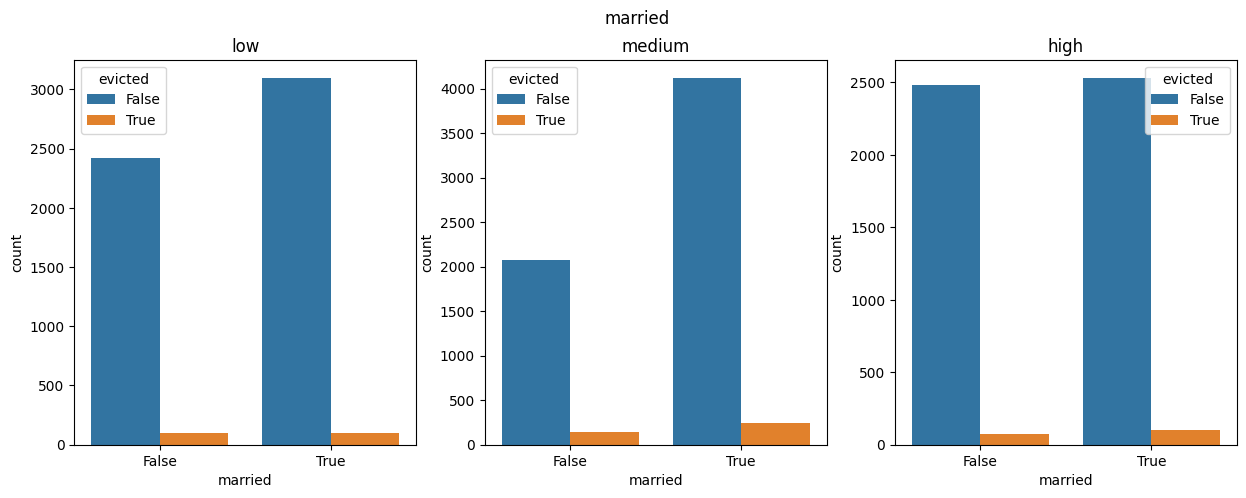

-------------------------------------------------------
Column:  citizen
	Dataset: low
		Value:  False
		- Evicted: 90 -> 3.562 %
		- Canceled: 2437 -> 96.438 %

		Value:  True
		- Evicted: 113 -> 3.5389999999999997 %
		- Canceled: 3080 -> 96.461 %

	Dataset: medium
		Value:  False
		- Evicted: 137 -> 6.244000000000001 %
		- Canceled: 2057 -> 93.756 %

		Value:  True
		- Evicted: 253 -> 5.7700000000000005 %
		- Canceled: 4132 -> 94.23 %

	Dataset: high
		Value:  False
		- Evicted: 84 -> 3.256 %
		- Canceled: 2496 -> 96.744 %

		Value:  True
		- Evicted: 93 -> 3.565 %
		- Canceled: 2516 -> 96.435 %



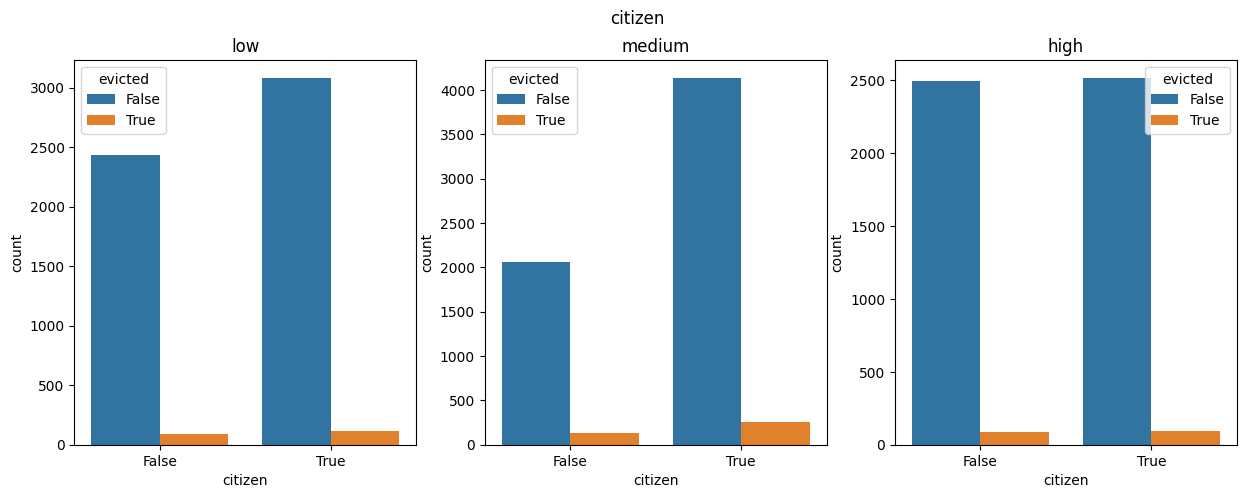

-------------------------------------------------------
Column:  protected
	Dataset: low
		Value:  False
		- Evicted: 163 -> 3.5680000000000005 %
		- Canceled: 4405 -> 96.432 %

		Value:  True
		- Evicted: 40 -> 3.472 %
		- Canceled: 1112 -> 96.528 %

	Dataset: medium
		Value:  False
		- Evicted: 350 -> 5.893000000000001 %
		- Canceled: 5589 -> 94.107 %

		Value:  True
		- Evicted: 40 -> 6.25 %
		- Canceled: 600 -> 93.75 %

	Dataset: high
		Value:  False
		- Evicted: 122 -> 3.319 %
		- Canceled: 3554 -> 96.681 %

		Value:  True
		- Evicted: 55 -> 3.6350000000000002 %
		- Canceled: 1458 -> 96.365 %



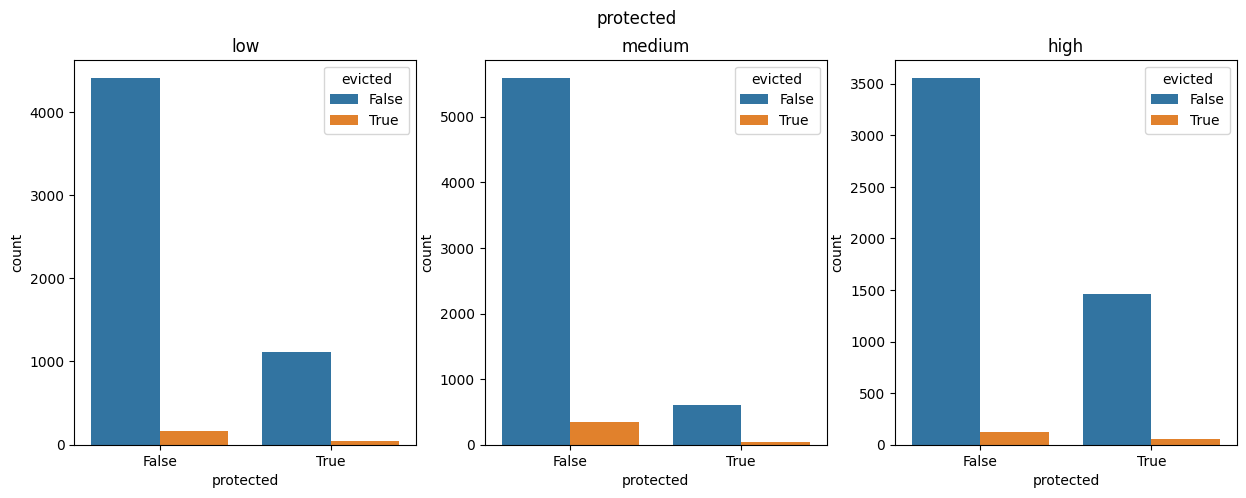

-------------------------------------------------------
Column:  yearsOfEducation
	Dataset: low
		Value:  1
		- Evicted: 7 -> 4.023000000000001 %
		- Canceled: 167 -> 95.977 %

		Value:  2
		- Evicted: 7 -> 6.087 %
		- Canceled: 108 -> 93.913 %

		Value:  3
		- Evicted: 2 -> 1.02 %
		- Canceled: 194 -> 98.98 %

		Value:  4
		- Evicted: 13 -> 4.8149999999999995 %
		- Canceled: 257 -> 95.185 %

		Value:  5
		- Evicted: 10 -> 2.941 %
		- Canceled: 330 -> 97.059 %

		Value:  6
		- Evicted: 12 -> 2.632 %
		- Canceled: 444 -> 97.368 %

		Value:  7
		- Evicted: 20 -> 4.024 %
		- Canceled: 477 -> 95.976 %

		Value:  8
		- Evicted: 30 -> 4.878 %
		- Canceled: 585 -> 95.122 %

		Value:  9
		- Evicted: 22 -> 3.288 %
		- Canceled: 647 -> 96.712 %

		Value:  10
		- Evicted: 26 -> 3.8350000000000004 %
		- Canceled: 652 -> 96.165 %

		Value:  11
		- Evicted: 20 -> 3.311 %
		- Canceled: 584 -> 96.68900000000001 %

		Value:  12
		- Evicted: 16 -> 3.6700000000000004 %
		- Canceled: 420 -> 96.33 %

		Val

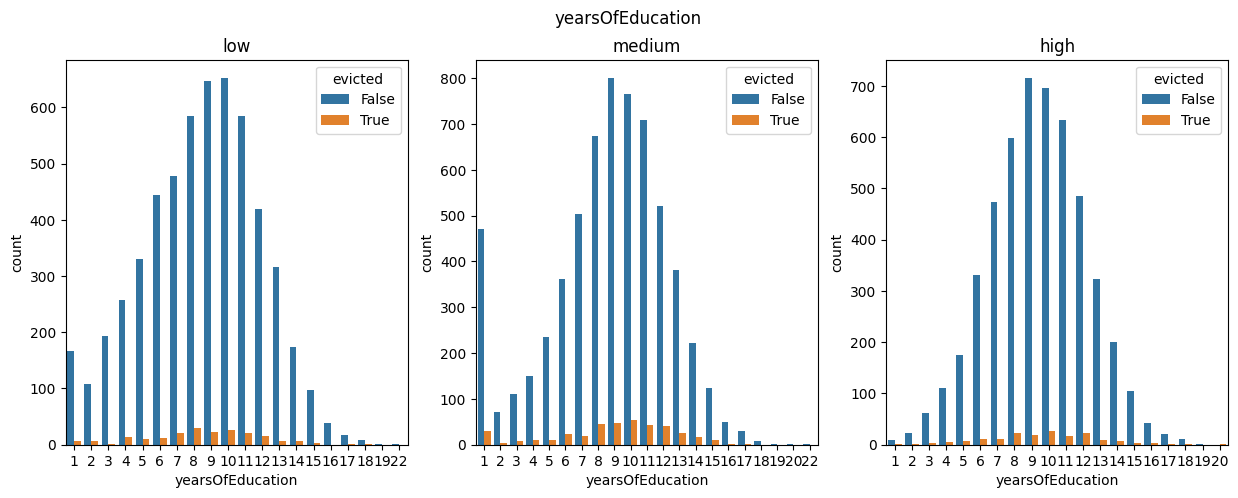

In [10]:
print_eviction_cancellation_counts()